%%latex

In [3]:
load("exp_hkst.RData")

In [9]:
save(file = "exp_hkst.RData")

Warning message in save(file = "exp_hkst.RData"):
“nothing specified to be save()d”


## Preliminaries

In [2]:
library(brms)
library(tidyverse)

#-------------------------------------------------------------------------------
#--- Useful functions
#-- find the root
#-------------------------------------------------------------------------------
GamF <- function(gam, p0) {
    (2 * pnorm(-abs(gam)) * exp(.5 * gam^2) - p0)^2
}

# optimize(GamF,interval = c(-30,30), p0=1 - 0.05)
GamBnd <- function(p0) {
    Re1 <- optimize(GamF, interval = c(-30, 30), p0 = 1 - p0)
    Re2 <- optimize(GamF, interval = c(-30, 30), p0 = p0)

    c(-abs(Re1$minimum), abs(Re2$minimum), Re1$objective, Re2$objective)
}
GamBnd <- Vectorize(GamBnd, "p0")

#-------------------------------------------------------------------------------
#--- Function
#-------------------------------------------------------------------------------
#--- Stan function (case 2)
tau0 <- .1


Bd <- GamBnd(tau0)[1:2]
# GAL2 <- custom_family(
#  "GAL2", dpars = c("mu", "sigma","ligam", "tau","gamL","gamU"), links=c("identity","log","identity","identity", rep("identity",2)),
#  lb=c(NA,0, -1.087,0,NA,NA), ub=c(NA,NA, 1.087,1,NA,NA), type="real") #, vars = "vint1[n]"
# GAL2 <- custom_family(
#   "GAL2", dpars = c("mu", "sigma","ligam"), links= c("identity","log","identity"),
#   lb=c(NA,0, -1.087), ub=c(NA,NA, 1.087), type="real", vars = c("tau","gamL","gamU")) #, vars = "vint1[n]"
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, -1.086, 0), ub = c(NA, NA, 1.086, 1), type = "real"
) # , vars = c("tau")) #, vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "logit", "identity"),
    lb = c(NA, 0, -15, 0), ub = c(NA, NA, 15, 1), type = "real", vars = c("gamL", "gamU")
) # , vars = c("tau")) #, vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau", "gamL", "gamU"), links = c("identity", "log", "identity", "identity", rep("identity", 2)),
    lb = c(NA, 0, -15, 0, NA, NA), ub = c(NA, NA, 15, 1, NA, NA), type = "real"
) # , vars = "vint1[n]"

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .99, 0), ub = c(NA, NA, Bd[2] * .99, 1), type = "real"
) # , vars = "vint1[n]"


stan_funs2 <- "
    /*
    A = -est*p_neg + .5*pow(gam, 2)*pow(p_neg/p_pos, 2) + log(Phi_approx(a2-a3)) + log1m_exp(fabs(log(Phi_approx(a2-a3)) - log(Phi_approx(a2))));
  gam = (gamU - gamL) * ligam + gamL;
  real gam = (gamU - gamL) * ligam + gamL;
  real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau, real gamL, real gamU){
  real GAL2_rng(real mu, real sigma, real ligam, real tau, real gamL, real gamU){
   */
     /* helper function for asym_laplace_lpdf
  * Args:
    *   y: the response value
  *   tau: quantile parameter in (0, 1)
  */
    real rho_quantile(real y, real tau) {
      if (y < 0) {
        return y * (tau - 1);
      } else {
        return y * tau;
      }
    }
  /* asymmetric laplace log-PDF for a single response
  * Args:
    *   y: the response value
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lpdf(real y, real mu, real sigma, real tau) {
      return log(tau * (1 - tau)) -
        log(sigma) -
        rho_quantile((y - mu) / sigma, tau);
    }
  /* asymmetric laplace log-CDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lcdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log(tau) + (1 - tau) * (y - mu) / sigma;
      } else {
        return log1m((1 - tau) * exp(-tau * (y - mu) / sigma));
      }
    }
  /* asymmetric laplace log-CCDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lccdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log1m(tau * exp((1 - tau) * (y - mu) / sigma));
      } else {
        return log1m(tau) - tau * (y - mu) / sigma;
      }
    }

   real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau){

   real p_pos;
   real p_neg;
   real a3;
   real a2;
   real p;
   real est;
   real A;
   real B;
   real Res = 0;
   real gam = ligam;
    p = (gam < 0) + (tau - (gam < 0))/(2*Phi(-fabs(gam))*exp(.5*pow(gam, 2)));
    p_pos = p -  (gam > 0);
    p_neg = p -  (gam < 0);
    est = (y - mu) / sigma;

    if(fabs(gam) > 0){
    a3 = p_pos * (est / fabs(gam));
    a2 = fabs(gam) * (p_neg / p_pos);


    if(est/gam > 0){
      A =  0.5*pow(gam, 2)*pow(p_neg/p_pos, 2) - est*p_neg + log_diff_exp(log(Phi_approx(a2-a3)), log(Phi_approx(a2)) );
      B =  0.5*pow(gam, 2) - p_pos*est + log(Phi_approx(-fabs(gam) + a3));
      Res = log(2*p*(1-p)) - log(sigma) +  log_sum_exp(A, B);
    }else{
      Res =  log(2*p*(1-p)) - log(sigma) - p_pos * est + 0.5 * pow(gam, 2) + log(Phi_approx(-fabs(gam) ));
    }
    }else{
    Res = asym_laplace_lpdf( y | mu, sigma, tau);
    }

    return Res;
   }

  real GAL2_rng(real mu, real sigma, real ligam, real tau){

     real A;
     real B;
     real C;
     real p;
     real hi;
     real nui;
     real mui=0;
     real Up = uniform_rng(.5, 1.0);

     real gam = ligam;
     p = (gam < 0) + (tau - (gam < 0))/(2*Phi_approx(-fabs(gam))*exp(.5*pow(gam, 2)));
     A = (1 - 2*p)/(p - pow(p,2));
     B = 2/(p - pow(p,2));
     C = 1/((gam > 0) - p);

      hi = sigma * inv_Phi(Up);
     nui = sigma * exponential_rng(1);
     mui += mu + A * nui + C * fabs(gam) * hi;

     return normal_rng(mui, sqrt(sigma*B*nui));
  }
  "


#--- Now define all of these here
# stanvars <- stanvar(scode = stan_funs, block = "functions")
stanvars2 <- stanvar(scode = stan_funs2, block = "functions")

# priorval = c(prior(normal(0, 15), class = "Intercept"),
#           # Prior guess of 80% of the terms are non-zero
#           prior(horseshoe(par_ratio =0.8), class = "b"))

#--- Fit the quantile regression
#-- quantile

# fit_fakeq.5 <- brms::brm(bf(as.formula(form), quantile = .5), data = df_sampleWt, family = asym_laplace(), prior = set_prior(horseshoe(df=1,par_ratio = 0.1), class="b"))
# fit_fakeq.5 <- brms::brm(bf(as.formula(form), quantile = .5), data = df_sampleWt, family = asym_laplace())

# fit_fakeqGal.5 <- brms::brm(bf(as.formula(form), tau = .5, gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL,
#                             stanvars = stanvars,chains = 3,iter = 10000, control = list(adapt_delta = 0.97, max_treedepth = 10))


# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = .5, gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 3,iter = 1000)
# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = .5,gamL = Bd[1], gamU = Bd[2]), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 2000, init = 0.1, control = list(adapt_delta = 0.97))

# fit_fakeqGal2.5 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,
# fit_fakeqGal2.9 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,
# fit_fakeqGal2.1 <- brms::brm(bf(as.formula(form), tau = tau0), data = df_sampleWt, family = GAL2, stanvars = stanvars2,chains = 2,iter = 5000, control = list(adapt_delta = 0.97)) # init = 0.1,


Loading required package: Rcpp

Loading 'brms' package (version 2.18.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Exponentially heteroskedastic data

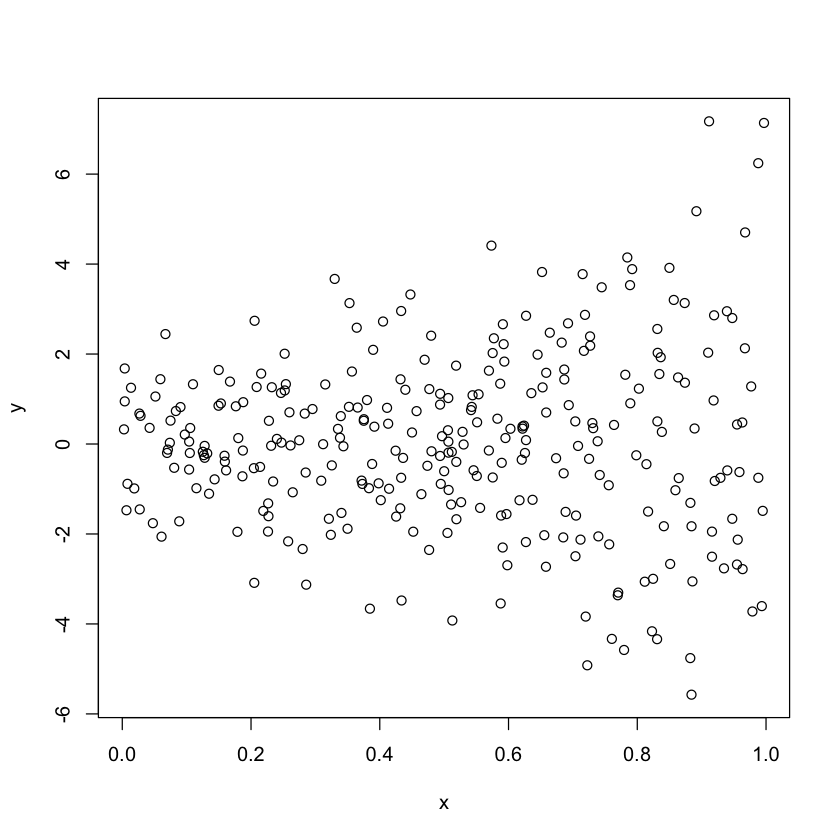

In [3]:
N <- 300
x <- runif(N, 0, 1)
y <- rnorm(N, mean = 0, sd = exp(x))

synthetic <- data.frame(x = x, y = y)
plot(x, y)

Compiling Stan program...

Start sampling



 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ exp(x) 
         sigma ~ x
         tau = 0.25
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept           0.36      0.40    -0.41     1.09 1.00     1319     1343
sigma_Intercept    -1.24      0.14    -1.52    -0.97 1.00     1029     1184
expx               -0.85      0.27    -1.37    -0.34 1.00     1158     1231
sigma_x             1.25      0.17     0.92     1.57 1.00     1313     1420

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
ligam     1.34      0.17     1.00     1.63 1.00      948     1108
tau       0.25      0.00     0.25     0.25   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter,

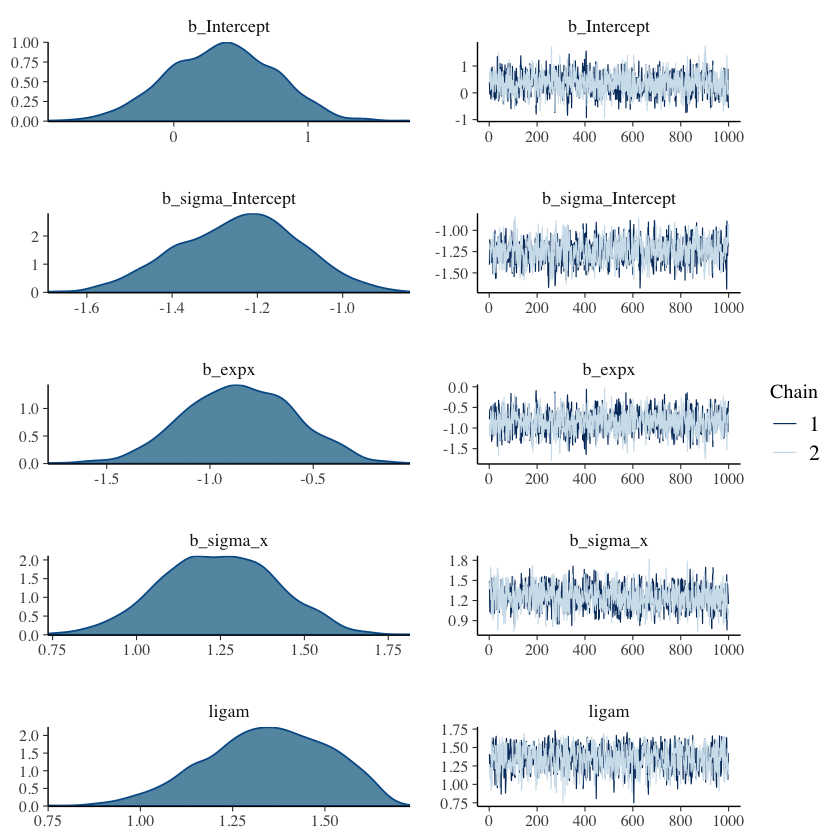

Warning message:
“The following parameters were dropped because they are constant: tau”


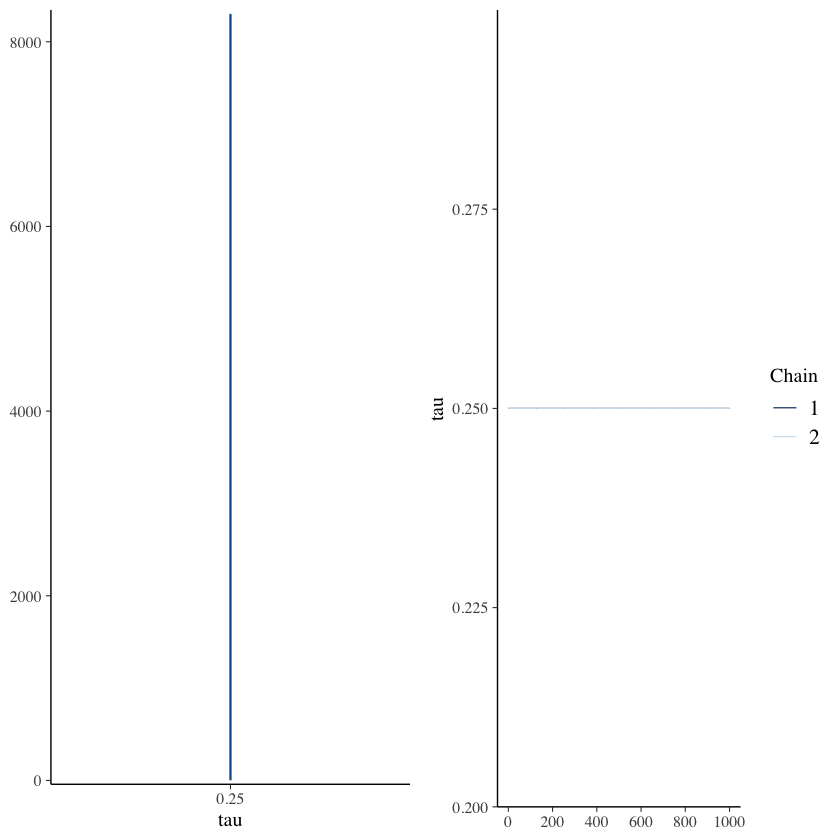

// generated with brms 2.18.0
functions {
  
    /*
    A = -est*p_neg + .5*pow(gam, 2)*pow(p_neg/p_pos, 2) + log(Phi_approx(a2-a3)) + log1m_exp(fabs(log(Phi_approx(a2-a3)) - log(Phi_approx(a2))));
  gam = (gamU - gamL) * ligam + gamL;
  real gam = (gamU - gamL) * ligam + gamL;
  real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau, real gamL, real gamU){
  real GAL2_rng(real mu, real sigma, real ligam, real tau, real gamL, real gamU){
   */
     /* helper function for asym_laplace_lpdf
  * Args:
    *   y: the response value
  *   tau: quantile parameter in (0, 1)
  */
    real rho_quantile(real y, real tau) {
      if (y < 0) {
        return y * (tau - 1);
      } else {
        return y * tau;
      }
    }
  /* asymmetric laplace log-PDF for a single response
  * Args:
    *   y: the response value
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lpdf(real y, real mu, real sigma, real tau) {
      return log(tau * (1 - tau)) -
        log(sigma) -
        rho_quantile((y - mu) / sigma, tau);
    }
  /* asymmetric laplace log-CDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lcdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log(tau) + (1 - tau) * (y - mu) / sigma;
      } else {
        return log1m((1 - tau) * exp(-tau * (y - mu) / sigma));
      }
    }
  /* asymmetric laplace log-CCDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lccdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log1m(tau * exp((1 - tau) * (y - mu) / sigma));
      } else {
        return log1m(tau) - tau * (y - mu) / sigma;
      }
    }

   real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau){

   real p_pos;
   real p_neg;
   real a3;
   real a2;
   real p;
   real est;
   real A;
   real B;
   real Res = 0;
   real gam = ligam;
    p = (gam < 0) + (tau - (gam < 0))/(2*Phi(-fabs(gam))*exp(.5*pow(gam, 2)));
    p_pos = p -  (gam > 0);
    p_neg = p -  (gam < 0);
    est = (y - mu) / sigma;

    if(fabs(gam) > 0){
    a3 = p_pos * (est / fabs(gam));
    a2 = fabs(gam) * (p_neg / p_pos);


    if(est/gam > 0){
      A =  0.5*pow(gam, 2)*pow(p_neg/p_pos, 2) - est*p_neg + log_diff_exp(log(Phi_approx(a2-a3)), log(Phi_approx(a2)) );
      B =  0.5*pow(gam, 2) - p_pos*est + log(Phi_approx(-fabs(gam) + a3));
      Res = log(2*p*(1-p)) - log(sigma) +  log_sum_exp(A, B);
    }else{
      Res =  log(2*p*(1-p)) - log(sigma) - p_pos * est + 0.5 * pow(gam, 2) + log(Phi_approx(-fabs(gam) ));
    }
    }else{
    Res = asym_laplace_lpdf( y | mu, sigma, tau);
    }

    return Res;
   }

  real GAL2_rng(real mu, real sigma, real ligam, real tau){

     real A;
     real B;
     real C;
     real p;
     real hi;
     real nui;
     real mui=0;
     real Up = uniform_rng(.5, 1.0);

     real gam = ligam;
     p = (gam < 0) + (tau - (gam < 0))/(2*Phi_approx(-fabs(gam))*exp(.5*pow(gam, 2)));
     A = (1 - 2*p)/(p - pow(p,2));
     B = 2/(p - pow(p,2));
     C = 1/((gam > 0) - p);

      hi = sigma * inv_Phi(Up);
     nui = sigma * exponential_rng(1);
     mui += mu + A * nui + C * fabs(gam) * hi;

     return normal_rng(mui, sqrt(sigma*B*nui));
  }
  
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int<lower=1> K_sigma;  // number of population-level effects
  matrix[N, K_sigma] 

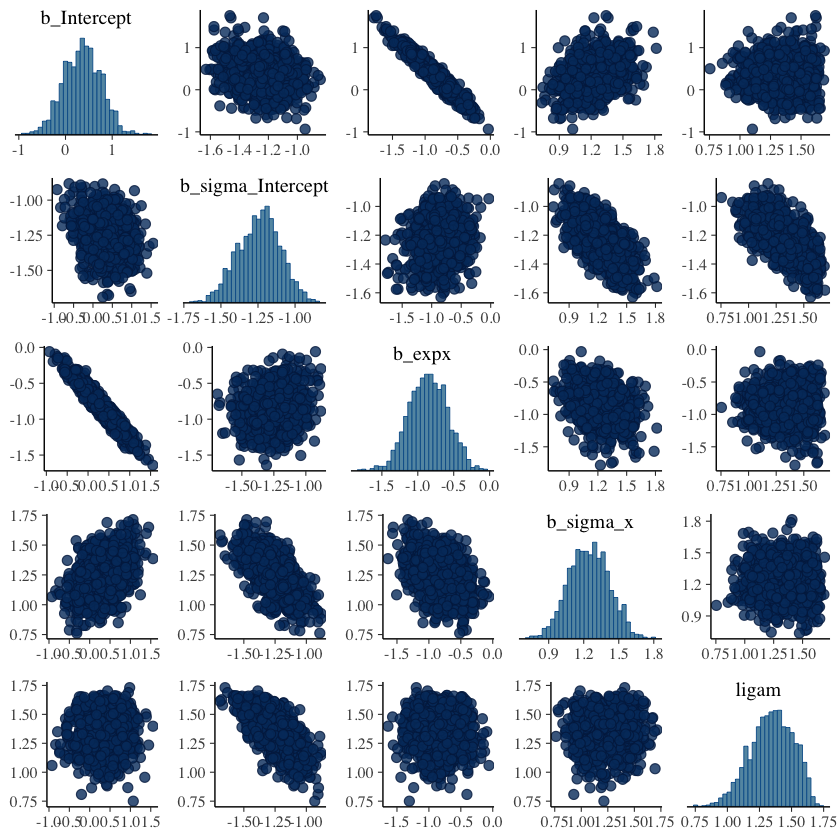

In [4]:
Bd <- GamBnd(.25)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q25 <- brm(bf(y ~ exp(x), sigma ~ x, tau = .25), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q25)
plot(q25)
pairs(q25)
stancode(q25)

## Back to the original goal

Compiling Stan program...

Start sampling



 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ exp(x) 
         sigma ~ x
         tau = 0.25
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept           0.36      0.40    -0.41     1.09 1.00     1319     1343
sigma_Intercept    -1.24      0.14    -1.52    -0.97 1.00     1029     1184
expx               -0.85      0.27    -1.37    -0.34 1.00     1158     1231
sigma_x             1.25      0.17     0.92     1.57 1.00     1313     1420

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
ligam     1.34      0.17     1.00     1.63 1.00      948     1108
tau       0.25      0.00     0.25     0.25   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter,

Compiling Stan program...

Start sampling

Warning message:
“There were 483 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning message:
“Parts of the model h

 Family: GAL2 
  Links: mu = identity; sigma = identity; ligam = identity; tau = identity 
Formula: y ~ exp(x) 
         tau = 0.25
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.69      0.44    -1.58     0.20 1.02      315      714
expx         -0.16      0.26    -0.71     0.33 1.01      527      794

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.41      0.26     0.13     0.74 1.84        3       92
ligam     1.78      0.73     0.76     2.53 1.84        3      148
tau       0.25      0.00     0.25     0.25   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split c

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”
Warning message:
“There were 483 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


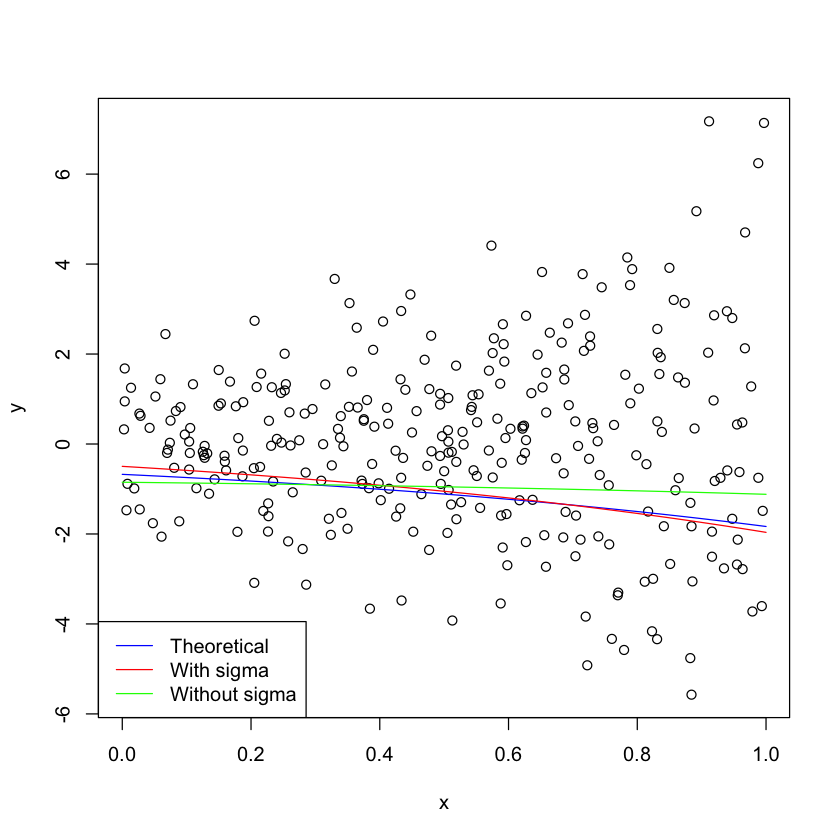

In [5]:
Bd <- GamBnd(.25)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q25 <- brm(bf(y ~ exp(x), sigma ~ x, tau = .25), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q25)

Bd <- GamBnd(.25)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q25n <- brm(bf(y ~ exp(x), tau = .25), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q25n)


In [4]:
xl <- seq(0, 1, .01)
tq25 <- qnorm(.25, 0, exp(xl))
cq25 <- summary(q25)$fixed[, "Estimate"]
gq25 <- cq25[1] + cq25[3] * exp(xl)
cq25n <- summary(q25n)$fixed[, "Estimate"]
gq25n <- cq25n[1] + cq25n[2] * exp(xl)

plot(x, y)
lines(xl, tq25, col = "blue")
lines(xl, gq25, col = "red")
lines(xl, gq25n, col = "green")
legend("bottomleft", legend = c("Theoretical", "With sigma", "Without sigma"), col = c("blue", "red", "green"), lty = 1)

ERROR: Error in summary(q25): object 'q25' not found


Compiling Stan program...

Start sampling

Warning message:
“There were 1710 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is NA, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning message:
“Parts of the model 

 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ exp(x) 
         sigma ~ x
         tau = 0.5
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept           0.20      0.38    -0.51     0.87 1.05       88      354
sigma_Intercept    -1.03      0.16    -1.43    -0.79 1.04       67       78
expx               -0.12      0.27    -0.60     0.41 1.18       11       83
sigma_x             1.24      0.19     0.86     1.61 1.03       76      275

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
ligam     0.01      0.27    -0.51     0.55 1.89        3       29
tau       0.50      0.00     0.50     0.50   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter, 

Compiling Stan program...

Start sampling

Warning message:
“There were 1617 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 12 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”
Warning message

 Family: GAL2 
  Links: mu = identity; sigma = identity; ligam = identity; tau = identity 
Formula: y ~ exp(x) 
         tau = 0.5
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.43      0.44    -1.28     0.36 1.03      123      217
expx          0.34      0.27    -0.14     0.87 1.03      108      266

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.74      0.05     0.65     0.83 1.01      163      348
ligam     0.24      0.05     0.18     0.38 1.02      123      192
tau       0.50      0.00     0.50     0.50   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split ch

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”
Warning message:
“There were 1710 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 1617 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


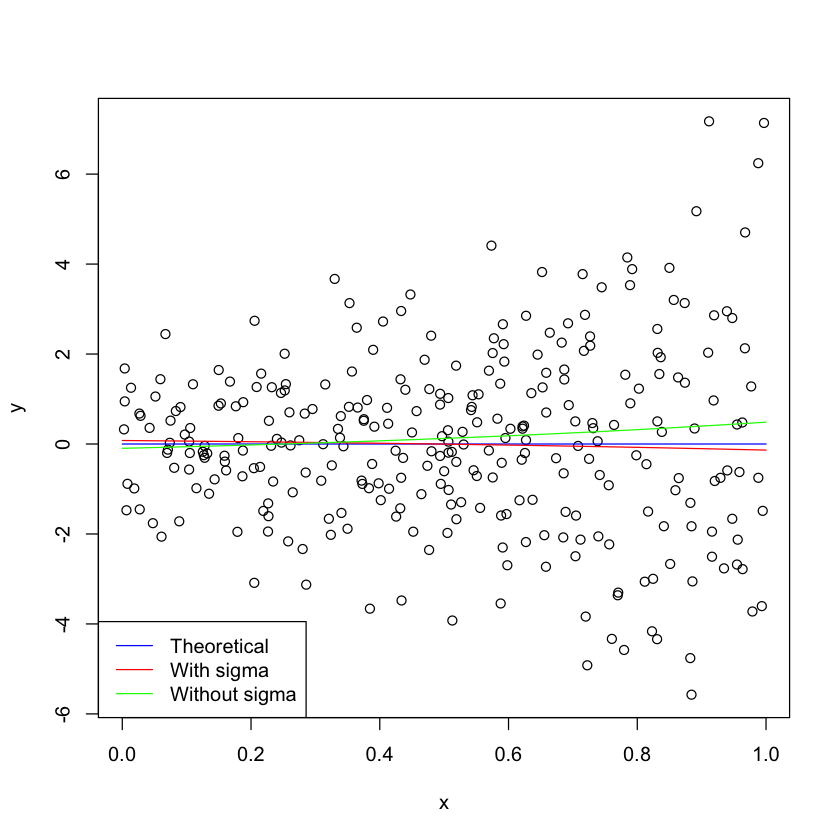

In [6]:
Bd <- GamBnd(.5)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q50 <- brm(bf(y ~ exp(x), sigma ~ x, tau = .5), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q50)

Bd <- GamBnd(.5)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q50n <- brm(bf(y ~ exp(x), tau = .5), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q50n)

xl <- seq(0, 1, .01)
tq50 <- qnorm(.5, 0, exp(xl))
cq50 <- summary(q50)$fixed[, "Estimate"]
gq50 <- cq50[1] + cq50[3] * exp(xl)
cq50n <- summary(q50n)$fixed[, "Estimate"]
gq50n <- cq50n[1] + cq50n[2] * exp(xl)

plot(x, y)
lines(xl, tq50, col = "blue")
lines(xl, gq50, col = "red")
lines(xl, gq50n, col = "green")
legend("bottomleft", legend = c("Theoretical", "With sigma", "Without sigma"), col = c("blue", "red", "green"), lty = 1)

Compiling Stan program...

Start sampling



 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: y ~ exp(x) 
         sigma ~ x
         tau = 0.75
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -0.13      0.42    -0.94     0.67 1.00      944     1027
sigma_Intercept    -1.21      0.13    -1.47    -0.96 1.01      894     1072
expx                0.75      0.28     0.22     1.29 1.00      847      984
sigma_x             1.19      0.17     0.85     1.52 1.00     1141     1062

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
ligam    -1.34      0.16    -1.62    -1.00 1.01      739     1291
tau       0.75      0.00     0.75     0.75   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter,

Compiling Stan program...

Start sampling



 Family: GAL2 
  Links: mu = identity; sigma = identity; ligam = identity; tau = identity 
Formula: y ~ exp(x) 
         tau = 0.75
   Data: synthetic (Number of observations: 300) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.17      0.42     0.34     1.93 1.00     1180     1088
expx         -0.01      0.25    -0.48     0.49 1.00     1126     1110

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.62      0.06     0.49     0.73 1.00      664      692
ligam    -1.24      0.19    -1.58    -0.87 1.00      637     1086
tau       0.75      0.00     0.75     0.75   NA       NA       NA

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split c

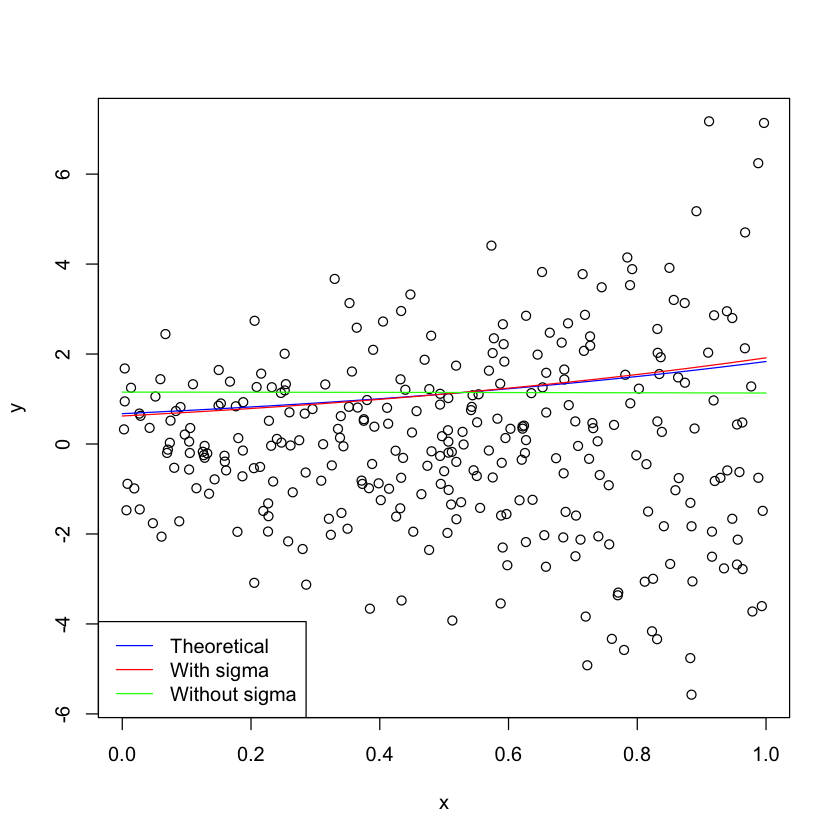

In [7]:

Bd <- GamBnd(.75)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q75 <- brm(bf(y ~ exp(x), sigma ~ x, tau = .75), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q75)

Bd <- GamBnd(.75)[1:2]
GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .9, 0), ub = c(NA, NA, Bd[2] * .9, 1), type = "real"
)
q75n <- brm(bf(y ~ exp(x), tau = .75), data = synthetic, family = GAL2, stanvars = stanvars2, chains = 2, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)
summary(q75n)

xl <- seq(0, 1, .01)
tq75 <- qnorm(.75, 0, exp(xl))
cq75 <- summary(q75)$fixed[, "Estimate"]
gq75 <- cq75[1] + cq75[3] * exp(xl)
cq75n <- summary(q75n)$fixed[, "Estimate"]
gq75n <- cq75n[1] + cq75n[2] * exp(xl)

plot(x, y)
lines(xl, tq75, col = "blue")
lines(xl, gq75, col = "red")
lines(xl, gq75n, col = "green")
legend("bottomleft", legend = c("Theoretical", "With sigma", "Without sigma"), col = c("blue", "red", "green"), lty = 1)
